As we are going to be using some python to visualize our data, let's just import all our packages right here.

In [14]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

# Validating Coherent Mesh Network

In this notebook we are going to look at the validation process of a cache hierarchy model for the Coherent Mesh Network (CMN) in gem5.
This cache hierarchy is used by the server class processors developed by ARM (more specifically in Neoverse N1 IP).
I have modeled this cache hierachy based on available information I could find online and my understanding of ARM AMBA CHI archietecture.
Here are some high level points about this cache hierarchy.

* As you can guess by the name the interconnect network is a Mesh that connects the cores to each other.
* The interconnect also hosts slices of the system level cache (abbv. SLC, similar to the last level cache by used system wide) where one slice is located at each point in the grid.
* Each slice of the system level cache is:
    * a victim cache (no allocate on read misses, allocate only on writebacks).
    * a home base for part of the physical memory address space: It acts as the directory for the addresses whose home is that slice.
* Connected to each slice is a *Core Tile* that encapsulates two Ares cores each with a 64KiB L1 instruction cache, 64KiB L1 data cache, and a 512KiB L2 Cache.

In this evaulation we are going to use a **8 core** system with **4 channels** of memory.
Below is a *logical* diagram of the system.

![logical digram of a system built with CMN](figures/cmn.png)


## Measuring core to core latency

In this section we will run experiments in gem5 to measure the latency of moving one cache block from one core (`provider`) to another core (`receiver`).
Since, to the best of my knowledge, the real hardware for CMN allows for forwarding clean data from the L2 cache (instead of the L1D cache) we are going to measure two latencies:

* Latency of moving a cache block from `provider` core to `receiver` core when the provider core has previously accessed that block for read shared (accessing only for read).
* Latency of moving a cache block from `provider` core to `receiver` core when the provider core has previously accessed that block for read unique (accessing for write).

Before looking at the results of the measurements, I want you to keep this important aspect of CMN in mind:
*Slices of the system level cache act as the directory for certain subset of the physical address space.*

You might have guess by now that the latency of moving a cache block at address `addr` from the `provider` core to the `receiver` core is a function of the following:
* Physical distance of `provider` core to the SLC responsible for `addr`.
* Physical distance of `receiver` core to the SLC responsible for `addr`.
* Physical distance of `provider` core and `receiver` core.

To keep these measurements limited only to the interconnect and the protocol we are going to use traffic generators instead of actuall processing cores.
Morevoer, in all the experiments we have assigned home bases to addresses by interleaving the addresses at a granularity of **512KiB**.

### Measuring core to core latency: read shared

This is the setup of the experiment:

1- The `provider` core will make a read request to address `addr` while all the other cores are idle.

2- We will wait long enough to make sure the data has arrived in the L1D cache of the `provider` core.

3- The `receiver` core will make a read request to address `addr` while all the other cores are idle.

4- We will measure the time between `receiver` core making the request and the data arriving at its L1D cache.

**NOTE**: The cores will make requests for **64B** reads.
This detail is not significant to the setup of this specific experiment but have been noted for the sake of consistency.

Let's put all of our data in a container in this notebook.

In [15]:
latency_data = pd.read_csv("data/latency_data.csv")

Below is a heatmap of the measured core to core latencies for address `addr = 0` (SLC0 is the home base for this address).

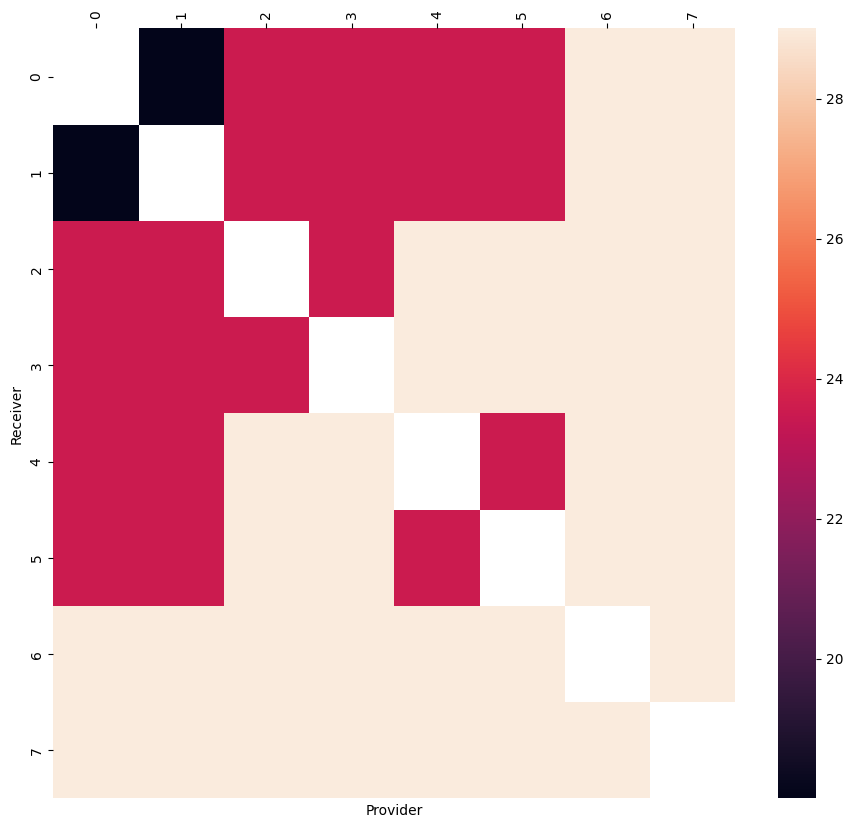

In [16]:
plt.figure(figsize=(11, 10))
data = latency_data[(latency_data["Sharing"] == "read") & (latency_data["Address"] == 0) & (latency_data["Size"] == 64)]
ax = sns.heatmap(data.pivot(index="Receiver", columns="Provider", values="Latency (ns)"))
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False, rotation=90)

Below is a heatmap of the measured core to core latencies for address `addr = 512K` (SLC1 is the home base for this address)

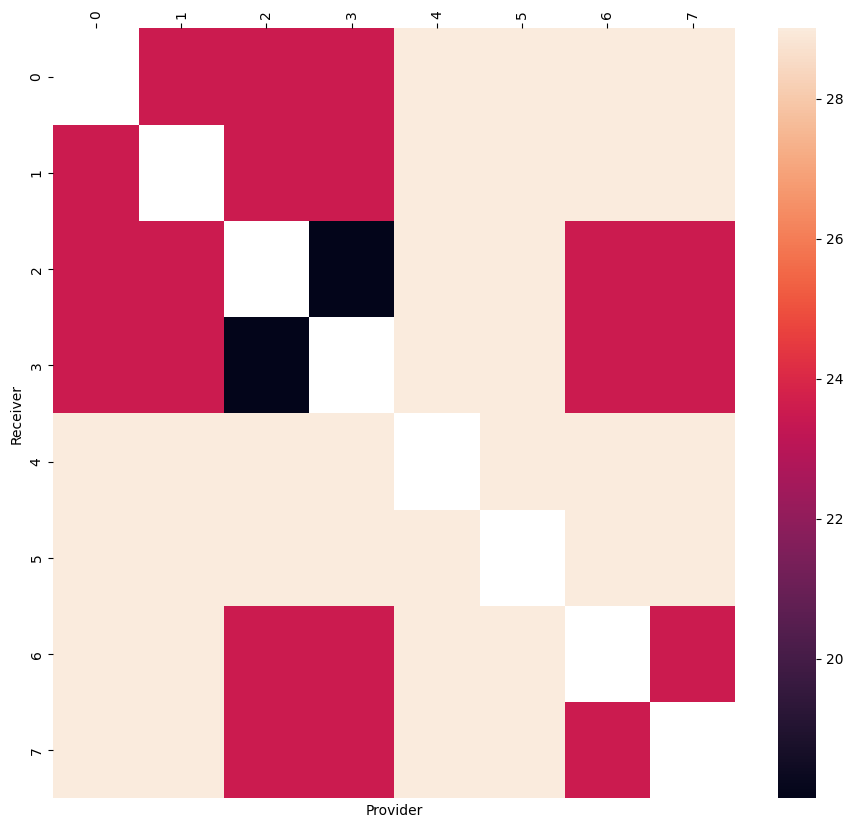

In [17]:
plt.figure(figsize=(11, 10))
data = latency_data[(latency_data["Sharing"] == "read") & (latency_data["Address"] == 524288) & (latency_data["Size"] == 64)]
ax = sns.heatmap(data.pivot(index="Receiver", columns="Provider", values="Latency (ns)"))
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False, rotation=90)

**NOTEWORTHY STUFF**

1- The last step in the coherence protocol is forwarding the data from the L2 cache of `provider` to L1D of `receiver`.

2- Notice how the heatmap is symmetrical to the main diagonal (latency(x->y) = latency(y->x))

3- Notice how by changing the shared address, the measured latencies change.
This is a behavior expected of home base system

### Measuring core to core latency: read unique (8B writes)

This is the setup of the experiment:

1- The `provider` core will make a write request to address `addr` while all the other cores are idle.

2- We will wait long enough to make sure the data has arrived in the L1D cache of the `provider` core.

3- The `receiver` core will make a write request to address `addr` while all the other cores are idle.

4- We will measure the time between `receiver` core making the request and the data arriving at its L1D cache.

**NOTE**: The cores will make requests for **8B** writes.

Below is a heatmap of the measured core to core latencies for address `addr = 0` (SLC0 is the home base for this address).

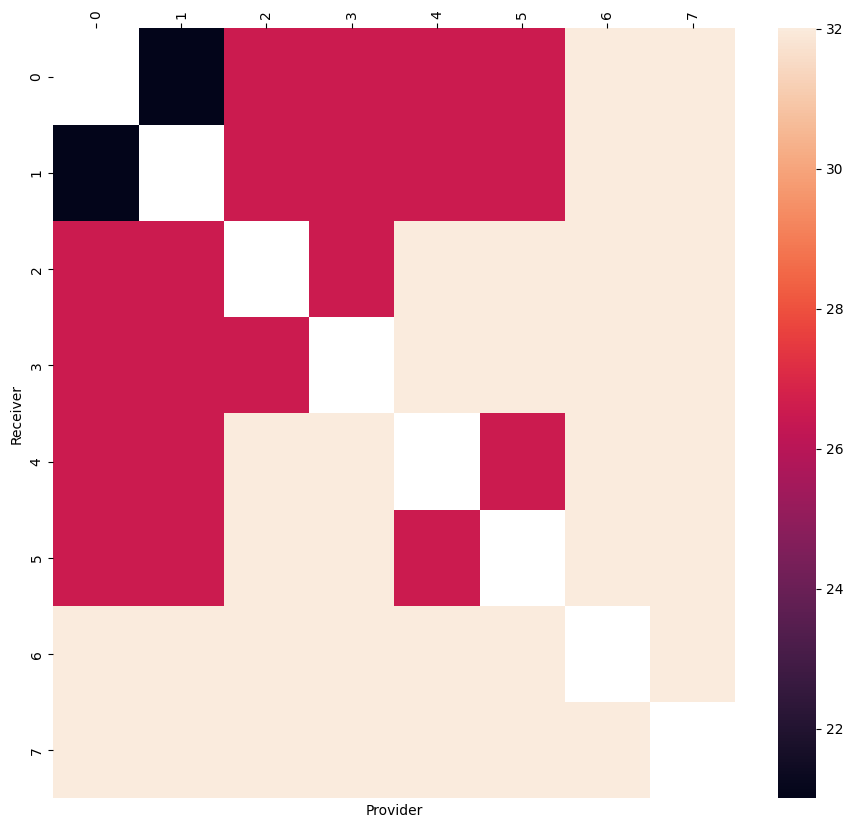

In [18]:
plt.figure(figsize=(11, 10))
data = latency_data[(latency_data["Sharing"] == "write") & (latency_data["Address"] == 0) & (latency_data["Size"] == 8)]
ax = sns.heatmap(data.pivot(index="Receiver", columns="Provider", values="Latency (ns)"))
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False, rotation=90)

Below is a heatmap of the measured core to core latencies for address `addr = 512K` (SLC1 is the home base for this address)

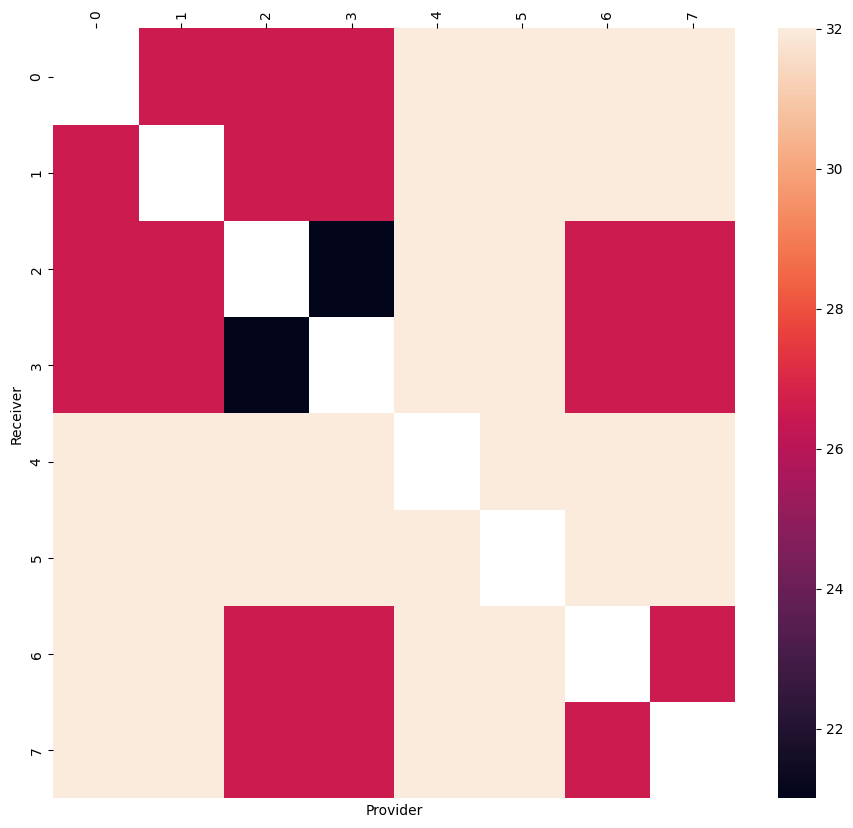

In [19]:
plt.figure(figsize=(11, 10))
data = latency_data[(latency_data["Sharing"] == "write") & (latency_data["Address"] == 524288) & (latency_data["Size"] == 8)]
ax = sns.heatmap(data.pivot(index="Receiver", columns="Provider", values="Latency (ns)"))
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False, rotation=90)

**NOTEWORTHY STUFF**

1- The last step in the coherence protocol is forwarding the data from the L1D cache of `provider` to L1D of `receiver` (SLC1: upper right corner in the diagram.)

2- Comparing these heatmaps with their counterparts in read shared, you will notice that moving cache blocks with read unique takes slightly longer than moving cache blocks with read shared.
They are different because in this scenario, the data has to be forwarded from L1D instead of L2.

3- Notice how the pattern between read shared and read unique is still similar, although sharing a cache block will require sending the data back to the SLC before sending it to the receiver core. 
My guess: CMN allows for forwarding shared dirty data, currently the model has this enabled.
To verify, I would run the same experiment with this feature disabled.

### Measuring core to core latency: read unique (64B writes)

This is the setup of the experiment:

1- The `provider` core will make a write request to address `addr` while all the other cores are idle.

2- We will wait long enough to make sure the data has arrived in the L1D cache of the `provider` core.

3- The `receiver` core will make a write request to address `addr` while all the other cores are idle.

4- We will measure the time between `receiver` core making the request and the data arriving at its L1D cache.

**NOTE**: The cores will make requests for **64B** writes.

Below is a heatmap of the measured core to core latencies for address `addr = 0` (SLC0 is the home base for this address).

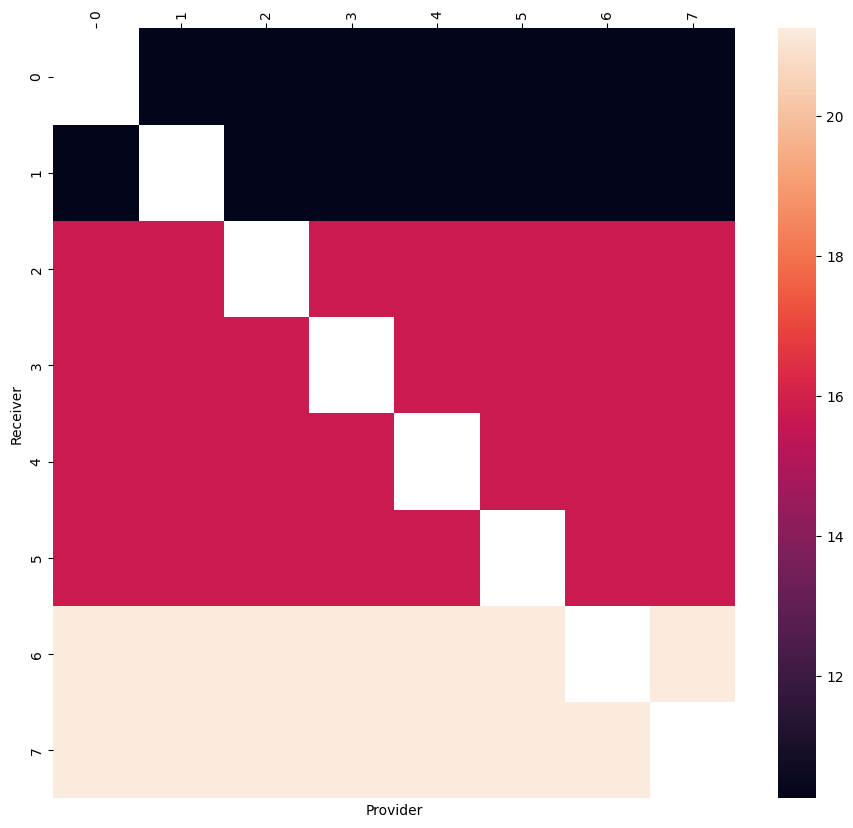

In [20]:
plt.figure(figsize=(11, 10))
data = latency_data[(latency_data["Sharing"] == "write") & (latency_data["Address"] == 0) & (latency_data["Size"] == 64)]
ax = sns.heatmap(data.pivot(index="Receiver", columns="Provider", values="Latency (ns)"))
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False, rotation=90)

Below is a heatmap of the measured core to core latencies for address `addr = 512K` (SLC1 is the home base for this address).

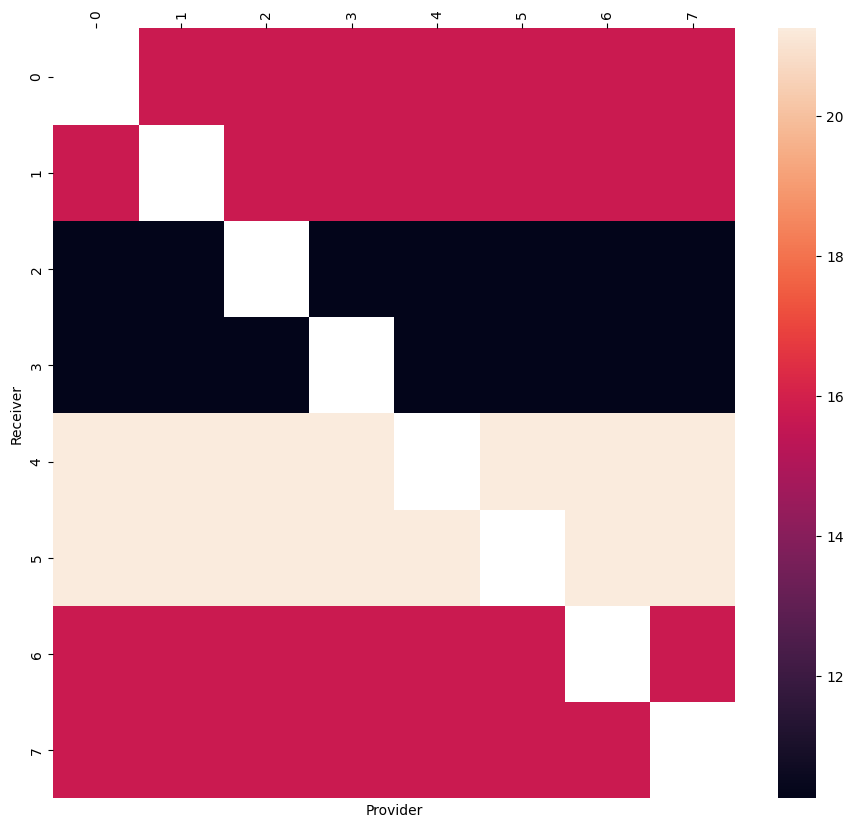

In [21]:
plt.figure(figsize=(11, 10))
data = latency_data[(latency_data["Sharing"] == "write") & (latency_data["Address"] == 524288) & (latency_data["Size"] == 64)]
ax = sns.heatmap(data.pivot(index="Receiver", columns="Provider", values="Latency (ns)"))
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False, rotation=90)

**NOTEWORTHY STUFF**

There is 1 very important point to take away from these heatmaps.
Before looking at the heatmap I expected to see a pattern similar to that of read unique (8B).
However, after further inspection I realized that when the cache receives a write to a complete cache block, the protocol allows the `receiver` core to write the local cache line without receiving the data from the `provider` core (The store instruction gets promoted to *WriteUniqueFull*).
Therefore, the measured latencies only measure the latency of `receiver` to the SLC and back (independent of `provider`).
This goes back to `alloc_on_seq_line_write` in CHI parameters.